# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [74]:
# Change here using YOUR first and last names
fn1 = "Salma"
ln1 = "El_Bez"
fn2 = "Sabina"
ln2 = "Hurtado"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_el_bez_salma_and_hurtado_sabina.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

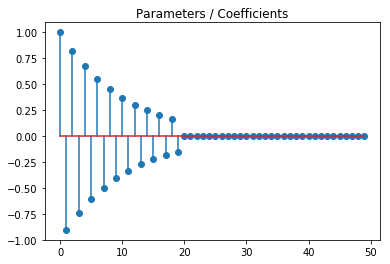

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [75]:
from numpy.linalg import norm 
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x""" 
    return np.sign(x)* np.maximum (np.abs(x)-s,0)
    
        
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s* norm(x)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x/(1+s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s*norm(x)**2 /2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

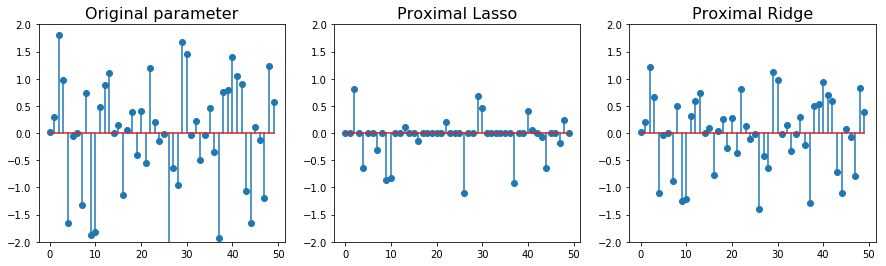

In [16]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

Original parameters present the solution without any penelization.We can check that the graphs are correct. The proximal lasso acts as expected since it puts all the values between -1 and 1 to 0 and takes off 1 for those who are big and inverse for those who are small ( proximal lasso shuts down some features: does feature selection). The proximal ridge acts also as expected. Its decreases the norm of the components of w. makes the solution not too complex in order for it to be easily generalized.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [76]:
def loss_linreg(x):
    """Least-squares loss"""
    return norm( A.dot(x)-b)**2 /(2*n_samples)

def grad_linreg(x):

    """Leas-squares gradient"""
    return A.T.dot(A.dot(x)-b)/n_samples
    

def loss_logreg(x):
    """Logistic loss"""
    return  np.average(np.log(1 + np.exp(-b * A.dot(x)) ))


def grad_logreg(x):
    """Logistic gradient"""
    return np.average ( (-b * A.T) *  (1/(1 + np.exp(b * A.dot(x)))), axis=1 )

In [41]:
from scipy.optimize import check_grad 
A,b= simu_linreg(coefs, n_samples)
check_grad(loss_linreg,grad_linreg,x)

5.12585610943725e-06

In [42]:
A,b=simu_logreg(coefs, n_samples)
check_grad(loss_logreg,grad_logreg,x)

1.1355668788830854e-07

## Part 3: Solvers

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [82]:

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return norm(A, 2)**2 / n_samples

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return norm(A, 2)**2 / (4*n_samples)
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s * step)
    
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [83]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x_new = prox_g(z - step * grad_f(z), s * step)
        t_new = (1 / 2) * (1 + np.sqrt(1 + 4 * (t ** 2)))
        z_new = x_new + ((t - 1) / t_new) * (x_new - x)
        
        x = x_new
        t = t_new
        z = z_new
        
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [84]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.20e+00 | 8.89e-01
      10 | 5.64e-01 | 3.42e-01
      20 | 5.01e-01 | 1.81e-01
      30 | 4.92e-01 | 1.41e-01
      40 | 4.91e-01 | 1.33e-01


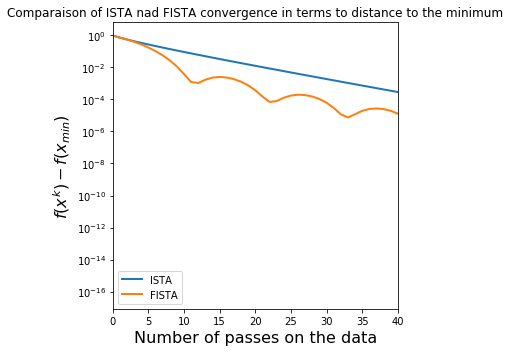

In [85]:
A,b= simu_linreg(coefs, n_samples)
result_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/lip_linreg(A_lin), s, n_iter, x_true= coefs, verbose=True)
result_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/lip_linreg(A_lin), s, n_iter= 1000,
                   x_true=coefs, verbose=False)
x_min = result_fista [0]
obj_min = result_fista[1][-1]

""" -------- graphs of the two algorithms----------"""

plt.figure(figsize=(6, 5))
plt.yscale("log")

# --------ISTA-------------
objectives= result_ista[1]
objectives_dist = objectives - obj_min 
plt.plot(objectives_dist, label="ISTA", lw=2)


#--------FISTA-------------
objectives= result_fista[1]
objectives_dist = objectives - obj_min 
plt.plot(objectives_dist, label="FISTA", lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$f(x^k) - f(x_{min})$", fontsize=16)
plt.title("Comparaison of ISTA nad FISTA convergence in terms to distance to the minimum")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()





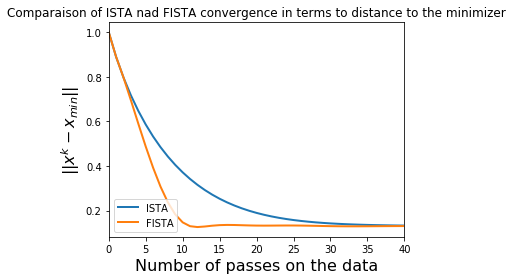

In [86]:
# --------ISTA-------------
errors= result_ista[2] 
plt.plot(errors, label="ISTA", lw=2)


#--------FISTA-------------
errors= result_fista[2]  
plt.plot(errors, label="FISTA", lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$ ||x^k - x_{min}||$", fontsize=16)
plt.title("Comparaison of ISTA nad FISTA convergence in terms to distance to the minimizer")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

We observe by comparing the performance of the two algorithms on the logarithm scale, that FISTA converges faster than ISTA 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

# Answers
-----
## Question 1

(-2, 2)

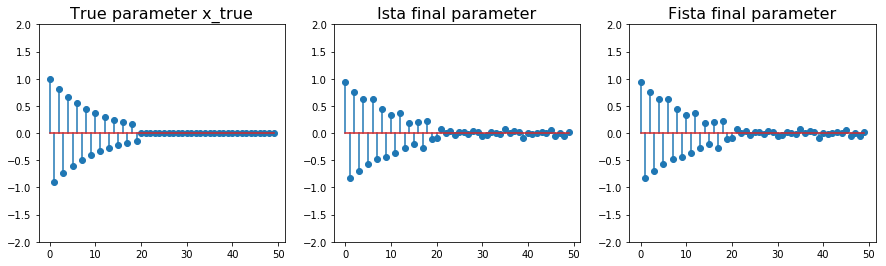

In [87]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("True parameter x_true", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
x_ista=result_fista[0]
plt.stem(x_ista)
plt.title("Ista final parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
x_fista=result_fista[0]
plt.stem(x_fista)
plt.title("Fista final parameter", fontsize=16)
plt.ylim([-2, 2])


## Question 2 : Influence of the correlation between features
**Linear regression**

/home/saaaab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/saaaab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


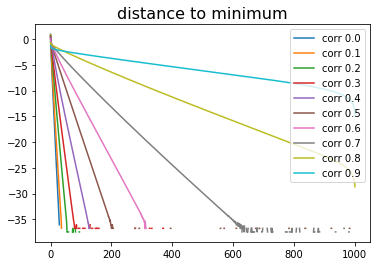

In [113]:
#study the influence of the correlation of the features
#on the performance of the optimization algorithms
#linear regression
##take ista as an example
#log(distance to minimum)
for i in range(10):
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.1*i)
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    L = 1/lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0, loss_linreg, grad_linreg, ridge,
                                  prox_ridge, L, s,n_iter, coefs, verbose=False)

    plt.plot(np.log(obj_ista - obj_ista[-1]), label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("distance to minimum", fontsize=16)
    plt.show

** Linear regression ** 

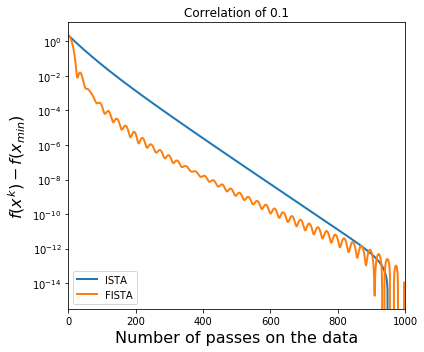

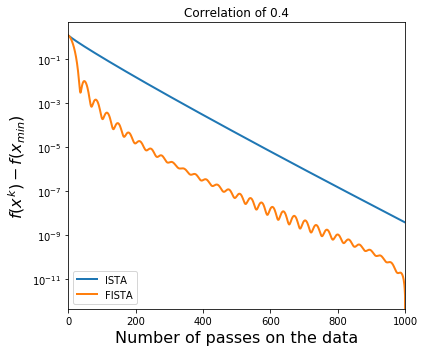

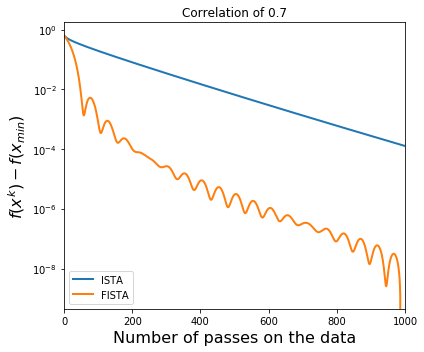

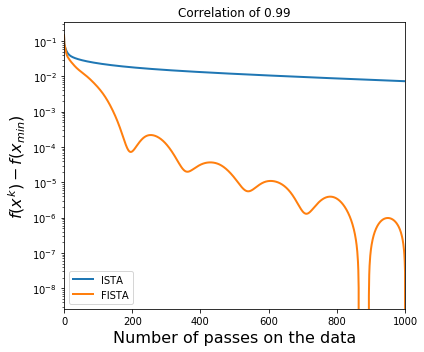

In [116]:
correlation = [0.1,0.4,0.7,0.99]

for i in range(len(correlation)):
    
    A, b = simu_linreg(coefs, corr=correlation[i])
    
    result_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/lip_linreg(A_lin), s, n_iter, x_true= coefs, verbose=False)
    result_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/lip_linreg(A_lin), s, n_iter,
                       x_true=coefs, verbose=False)
    x_min = result_fista [0]
    obj_min = result_fista[1][-1]

    """ -------- graphs of the two algorithms----------"""

    plt.figure(figsize=(6, 5))
    plt.yscale("log")

    # --------ISTA-------------
    objectives= result_ista[1]
    objectives_dist = objectives - obj_min 
    plt.plot(objectives_dist, label="ISTA", lw=2)


    #--------FISTA-------------
    objectives= result_fista[1]
    objectives_dist = objectives - obj_min 
    plt.plot(objectives_dist, label="FISTA", lw=2)

    plt.tight_layout()
    plt.xlim((0, n_iter))
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$f(x^k) - f(x_{min})$", fontsize=16)
    plt.title("Correlation of "+str(correlation[i]))
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

**Logistic regression**

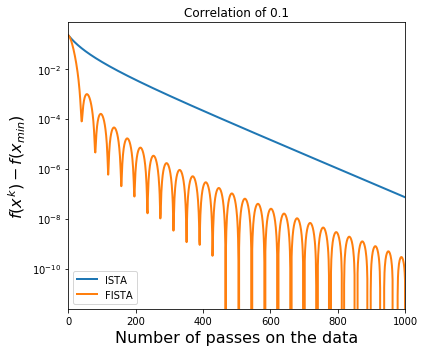

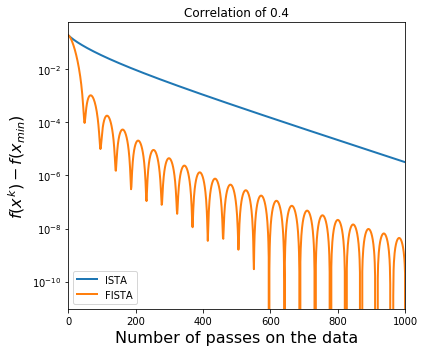

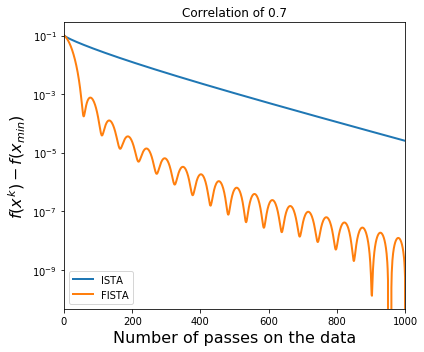

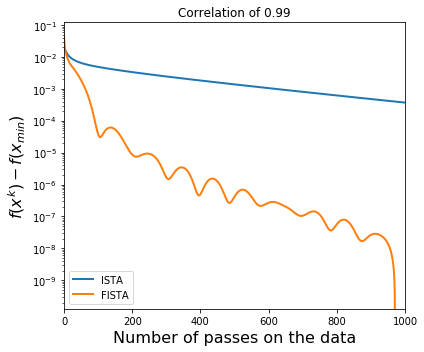

In [117]:
correlation = [0.1,0.4,0.7,0.99]

for i in range(len(correlation)):
    
    A, b = simu_logreg(coefs, corr=correlation[i])
    
    result_ista = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/lip_logreg(A_log), s, n_iter, x_true= coefs, verbose=False)
    result_fista = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/lip_logreg(A_log), s, n_iter,
                       x_true=coefs, verbose=False)
    x_min = result_fista [0]
    obj_min = result_fista[1][-1]

    """ -------- graphs of the two algorithms----------"""

    plt.figure(figsize=(6, 5))
    plt.yscale("log")

    # --------ISTA-------------
    objectives= result_ista[1]
    objectives_dist = objectives - obj_min 
    plt.plot(objectives_dist, label="ISTA", lw=2)


    #--------FISTA-------------
    objectives= result_fista[1]
    objectives_dist = objectives - obj_min 
    plt.plot(objectives_dist, label="FISTA", lw=2)

    plt.tight_layout()
    plt.xlim((0, n_iter))
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$f(x^k) - f(x_{min})$", fontsize=16)
    plt.title("Correlation of "+str(correlation[i]))
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


    
    
    

**Comments**

We have varied the correlation parameter when creating the data. We notice that for both models (linear and logistic regression), the behaviour of the optimization algorithms is the same.

  * For ista: the the algorithm becomes less performant when the features are more correlated.
  * For fista: also the algorithm is less performant when the features are more correlated.
 
 En general, algorithms become less efficient when the income observations are correlated. This is probably due to the fact that the loss function becomes less and less "convexe" = more plain, when the features are correlated. Therefore, it becomes
more difficult for the gradient to converge to the optimal solution. 


## Influence of ridge penalization


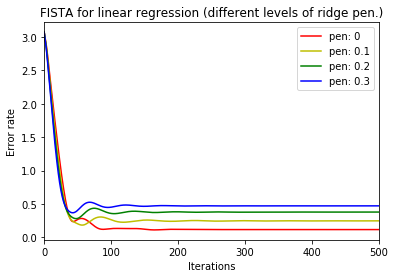

In [121]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = 1/lip_linreg(A_lin)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, L, s=0, n_iter =500, verbose=False)
Z1 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, L, s=0.1, n_iter =500, verbose=False)
Z2 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, L, s=0.2, n_iter =500,verbose=False)
Z3 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, L, s=0.3, n_iter =500, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.title('FISTA for linear regression (different levels of ridge pen.)')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 500)
plt.legend()
plt.show()

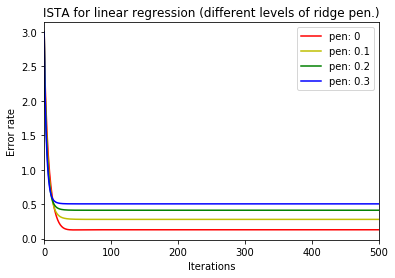

In [124]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =500, verbose=False)
Z1 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =500, verbose=False)
Z2 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =500, verbose=False)
Z3 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =500, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA for linear regression (different levels of ridge pen.)')

plt.xlim(0, 500)
plt.legend()
plt.show()



We observe that the convergence speed is greater when the penalization is increased. Nevertheless, the error rate converges to a higher value when the penalization is higher. This is due to the fact that, as we saw before, the penalization affects the magnitude of the coefficients ; therefore, the higher the penalization parameter, the lower the coefficients. As a consequence, the error rate associated to a higher penalization is higher. In any case, FISTA converges still faster than ISTA.


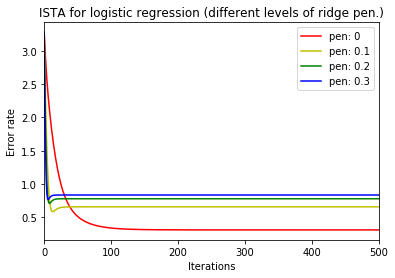

In [126]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =500, verbose=False)
Z1 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =500, verbose=False)
Z2 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =500, verbose=False)
Z3 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =500, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA for logistic regression (different levels of ridge pen.)')

plt.xlim(0, 500)
plt.legend()
plt.show()


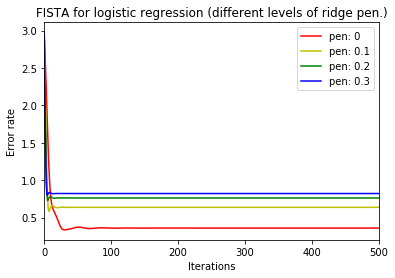

In [127]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =500, verbose=False)
Z1 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =500, verbose=False)
Z2 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =500, verbose=False)
Z3 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =500, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('FISTA for logistic regression (different levels of ridge pen.)')

plt.xlim(0, 500)
plt.legend()
plt.show()


## Comparison of Ridge and Lasso for performance


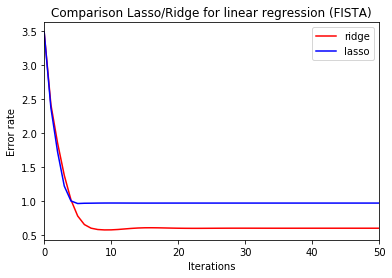

In [128]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50, verbose=False)
Z1 = fista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for linear regression (FISTA)')

plt.xlim(0, 50)
plt.legend()
plt.show()

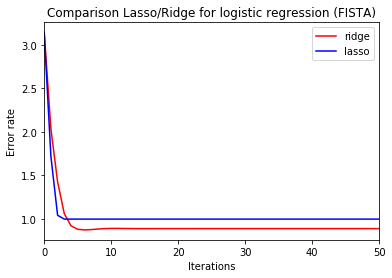

In [129]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50, verbose=False)
Z1 = fista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50, verbose=False)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for logistic regression (FISTA)')

plt.xlim(0, 50)
plt.legend()
plt.show()


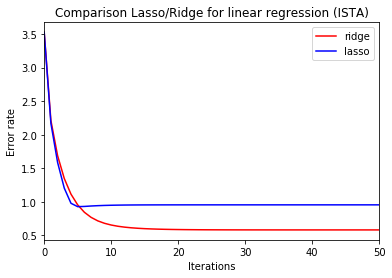

In [130]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50, verbose=False)
Z1 = ista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50, verbose=False)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for linear regression (ISTA)')

plt.xlim(0, 50)
plt.legend()
plt.show()

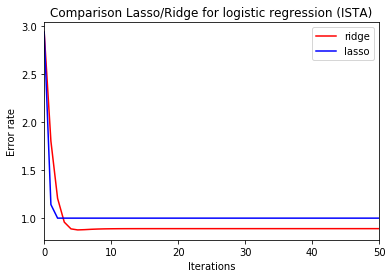

In [131]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50, verbose=False)
Z1 = ista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=1, n_iter =50, verbose=False)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for logistic regression (ISTA)')

plt.xlim(0, 50)
plt.legend()
plt.show()